# Quantum Machine Learning

Eigenvalue problem

In [2]:
import os
import qiskit

from qiskit import *

from qiskit_aer import Aer
from qiskit_aer import *

from qiskit.visualization import *

# SciPy minimizer routine
from scipy.optimize import minimize
import time
import numpy as np


In [3]:
with open(os.path.expanduser('~')+"/Documents/keys/ibm-token.txt") as f:
    # Newline character must be excluded
    IBM_token = f.readline()[:-1]

$
\hat{O} = 2 \mathcal{I}\mathcal{I} - 2 \mathcal{X}\mathcal{X} + 3 \mathcal{Y}\mathcal{Y} -3 \mathcal{Z}\mathcal{Z}$

In [4]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

## Or via triples and local Paulis with indices
# observable = SparsePauliOp.from_sparse_list([("II", [0, 1], 2), ("XX", [0, 1], -2),("YY", [0, 1], 3),("XX", [0, 1], -3)], num_qubits=127)
# observable.num_qubits

In [5]:

from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

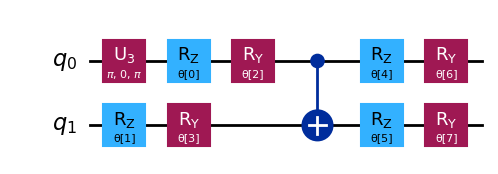

In [6]:
import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

# In Simulator 

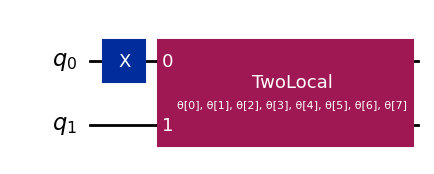

In [7]:
from qiskit import transpile
ansatz_sim=transpile(ansatz)
ansatz_sim.draw(output="mpl")

In [8]:
from qiskit.primitives import Estimator

backend = Aer.get_backend('qasm_simulator')

# x0 is the initial values of the parameters
x0 = np.ones(8) * np.pi/4

estimator = Estimator()
estimator.shots=512

res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_sim, observable, estimator),
    method="cobyla",
)



In [9]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999968692013
       x: [ 2.029e+00  5.615e-01  1.571e+00 -5.988e-06  1.366e+00
            1.775e+00  1.227e+00  1.227e+00]
    nfev: 130
   maxcv: 0.0

# In Real Quantum Computer

In [22]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

In [23]:
# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', instance='ibm-q/open/main', token=IBM_token)

In [24]:

backend=service.least_busy(operational=True, simulator=False)
print(backend.name)
session = Session(backend=backend)
estimator = Estimator(session=session)
sampler = Sampler(session=session)

ibm_kyoto


In [25]:
print(ansatz.num_qubits)
ansatz_ibm=transpile(ansatz,backend=backend)
print(ansatz_ibm.num_qubits)
print(observable.num_qubits)
observable_ibm = observable.apply_layout(ansatz_ibm.layout)
print(observable_ibm.num_qubits)

2
127
2
127


In [26]:
options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 1024

with Session(backend=backend):
    estimator = Estimator(options=options)
    res = minimize(
        cost_func_vqe,
        x0,
        args=(ansatz_ibm, observable_ibm, estimator),
        method="cobyla"
    )

## # In v2, I am gonna introduce callback function to make it more convenient for post processing

/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)
Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/scipy/optimize/_cobyla_py.py", line 258, in calcfc
    f = fun(np.copy(x), *args)
  File "/var/folders/lx/_zyyxd0945x3lbrz0g5vm9940000gn/T/ipykernel_10099/176364455.py", lin

: 

/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:935: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)

In [8]:
jobid= "cqs37b54x0mg008jg5zg"
retrieved_job = backend.service.job(jobid)
retrieved_job.result()

127